# Data Mining: exam text analysis

- Pablo Vizán Siso
- 7438214

## Question 2

### Choose two genres from the song dataset from exercise 3.1 to examine and compare the gender bias in songs of both genres. Explain why the two genres you choose are relevant to compare in this context, and formulate a hypothesis.

The genres I will choose are Pop and Metal. I think it is interesting to compare this to genres because of how different they are:

- Pop is a genre that has mainstream appeal. The lyrics usually deal with experiences that are common to most people: love, relationships, friends, parties, etc. Personally, I feel popstars are not mostly men nor women, or if they are is not by a long shot. Analogously, I also expect the audience to be rather homogenuous in terms of gender.


- Metal, on the other hand, has more of an alternative appeal. The lyrics usually do not deal with mainstream topics like the ones pop deals with, but rather evoke fantasy and horror imagery, as well as feelings of pain and anger. My impression is that most metal music is created by male artists and in general more targeted to a male-dominated audience.

Given my initial assumptions, I am going to test the hypothesis that **metal music has a more pronounced gender bias towards men than pop**.

### Train two word embeddings models (one for each genre), and use the lists of female and male words uploaded to BB (Assignments / exam 1 / question 2) for your analysis. Compare the biases between the two genres you choose using the method by Wevers. Interpret the results and relate them to your hypothesis.

Below, I will import the necessary packages for the analysis

In [6]:
# Counter
from collections import Counter

# gensim
import gensim
from gensim.models import Word2Vec

# json
import json

# matplotlib
from matplotlib import pyplot as plt

# numpy
import numpy as np

# pandas
import pandas as pd

# pickle
import pickle

# tqdm
from tqdm import tqdm, tqdm_notebook

# spacy
import spacy
nlp = spacy.load("en_core_web_sm")

Before anything, I will apply a correction on the data that was suggested in the assignment where we had to use this data set.

In [ ]:
PATH_DF = 'english_cleaned_lyrics.csv'
PATH_CORRECTION = 'indx2newdate.p'

def load_dataset(data_path, path_correction):
    df = pd.read_csv(data_path)
    indx2newdate = pickle.load(open(PATH_CORRECTION, 'rb'))
    df['year'] = df['index'].apply(lambda x: int(indx2newdate[x][0][:4]) if indx2newdate[x][0] != '' else 0)
    return df[df.year > 1960][['song', 'year', 'artist', 'genre', 'lyrics']]
    
dataset = load_dataset(PATH_DF, PATH_CORRECTION)

Now, I will start by processing the lyrics of the pop and metal songs of the dataset. I will exclude those songs from years where there were less than 50 songs of the particular genre.

I will also save the lemmas of the lyrics to a json file, so I don't have to rerun the tokenizer every time I restart the runtime.

In [ ]:
pop = dataset[dataset.genre == "Pop"]
pop_ids = pop.groupby(by="year").count()["song"].apply(lambda v: v if v <= 50 else None).dropna().index
pop_data = pop[~pop.year.isin(pop_ids)].lyrics.values

processed_texts = [text 
                   for text in tqdm_notebook(
                       nlp.pipe(
                           pop_data, n_process=-1, disable=["ner", "parser"]
                           ), total=len(data)
                   )
                   ]
pop_lemma = [
         [token.lemma_ for token in text if not token.is_punct and not token.is_stop] 
         for text in processed_texts
         ]
with open('pop_lemma.json', 'w') as file:
    json.dump(pop_lemma, file)

In [ ]:
metal = dataset[dataset.genre == "Metal"]
metal_ids = metal.groupby(by="year").count()["song"].apply(lambda v: v if v <= 50 else None).dropna().index
metal_data = metal[~metal.year.isin(metal_ids)].lyrics.values

processed_texts = [text 
                   for text in tqdm_notebook(
                       nlp.pipe(
                           metal_data, n_process=-1, disable=["ner", "parser"]
                           ), total=len(data)
                   )
                   ]
metal_lemma = [
         [token.lemma_ for token in text if not token.is_punct and not token.is_stop] 
         for text in processed_texts
         ]
with open('metal_lemma.json', 'w') as file:
    json.dump(metal_lemma, file)

In [4]:
with open('pop_lemma.json') as json_file:
    pop_lemma = json.load(json_file)
    
with open('metal_lemma.json') as json_file:
    metal_lemma = json.load(json_file)

Now, I will create two models (one for each genre) and train them with their respective dictionaries of lemmas.

In [7]:
SIZE = 300 
SG = 1 
WINDOW = 10 
N_WORKERS = 1 
MIN_COUNT = 5

pop_model = Word2Vec(size=SIZE,
                sg=SG,
                window=WINDOW, 
                min_count=MIN_COUNT,
                workers=N_WORKERS)

pop_model.build_vocab(pop_lemma)

pop_model.train(pop_lemma,
           total_examples=pop_model.corpus_count,
           epochs=pop_model.epochs) 

(9218085, 11465035)

In [8]:
metal_model = Word2Vec(size=SIZE,
                sg=SG,
                window=WINDOW, 
                min_count=MIN_COUNT,
                workers=N_WORKERS)

metal_model.build_vocab(metal_lemma)

metal_model.train(metal_lemma,
           total_examples=metal_model.corpus_count,
           epochs=metal_model.epochs)

(5695530, 6400640)

Let's now open word_cats.p. This file contains words representing the following categories: 

- affect: Affect
- posemo: Positive emotions
- negemo: Negative emotions
- social: Social
- family: Family
- cogproc: Cognitive Processes
- percept: Perceptual Processes
- body: Body
- work: Work
- leisure: Leisure
- money: Money
- relig: Religion
- occupation: Occupation

In [9]:
word_cats = pickle.load(open('word_cats.p', 'rb'))

In [10]:
word_cats.head()

,affect,posemo,negemo,social,family,cogproc,percept,body,work,leisure,money,relig,occupation
0,protesting,incentive,destruction,chick,ma's,comply,squeez,pussy,dotcom,dnd,portfolio,goddess,accountant
1,pretty,luck,beaten,ma's,niece,luck,sand,wears,employee,vacation,sale,karma,actor
2,sighs,freeing,battl,lets,stepkid,unquestion,moist,hearts,paper,hobb,stores,pastor,actress
3,warmth,pretty,protesting,son's,son's,pretty,warmth,asleep,earns,band,bets,temple,actuary
4,mooch,nicely,dumber,daddies,daddies,become,gloomy,gums,assign,skat,bank,holy,acupuncturist


I will first use the word embeddings of the Pop model. I will calculate the mean for the male and female word embeddings, respectively, in order to calculate Frobenius norms in the next step.

In [11]:
male_words = pickle.load(open('male_words.p', 'rb'))
female_words = pickle.load(open('female_words.p', 'rb'))

# male
pm_words = [word for word in male_words if word in pop_model.wv.vocab]
pm_mean_embedding = np.mean([pop_model.wv[word] for word in pm_words], axis=0)

# female
pf_words = [word for word in female_words if word in pop_model.wv.vocab]
pf_mean_embedding = np.mean([pop_model.wv[word] for word in pf_words], axis=0)

I will calculate now the Frobenius norm for each gender, which is defined as the square root of the sum of the absolute squares of its elements.

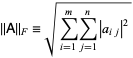

The difference between both Frobenius norms will result in the bias score of each word, which will be male leaning if it's below 1 and female leaning if it's above 1.

In [12]:
p_male_distance = lambda x: np.linalg.norm(np.subtract(pop_model.wv[x], pm_mean_embedding)) if x in pop_model.wv.vocab else None
p_female_distance = lambda x: np.linalg.norm(np.subtract(pop_model.wv[x], pf_mean_embedding)) if x in pop_model.wv.vocab else None
p_total_bias = lambda x: p_male_distance(x) - p_female_distance(x) if x in pop_model.wv.vocab else None


pop_bias = word_cats.applymap(p_total_bias)

Once I have calculated the bias score according to pop_model, I will do the same with metal_model.

In [13]:
# male
mm_words = [word for word in male_words if word in metal_model.wv.vocab]
mm_mean_embedding = np.mean([metal_model.wv[word] for word in mm_words], axis=0)

# female
mf_words = [word for word in female_words if word in metal_model.wv.vocab]
mf_mean_embedding = np.mean([metal_model.wv[word] for word in mf_words], axis=0)

In [14]:
m_male_distance = lambda x: np.linalg.norm(np.subtract(metal_model.wv[x], mm_mean_embedding)) if x in metal_model.wv.vocab else None
m_female_distance = lambda x: np.linalg.norm(np.subtract(metal_model.wv[x], mf_mean_embedding)) if x in metal_model.wv.vocab else None
m_total_bias = lambda x: m_male_distance(x) - m_female_distance(x) if x in metal_model.wv.vocab else None


metal_bias = word_cats.applymap(m_total_bias)

Done! We can now inspect the results and check out our findings.

In [15]:
pd.DataFrame(data=[pop_bias.mean(), metal_bias.mean()], index=['pop', 'metal'])

,affect,posemo,negemo,social,family,cogproc,percept,body,work,leisure,money,relig,occupation
pop,0.015961,0.033942,0.000958,-0.025876,-0.039070,0.013671,0.009714,-0.052860,-0.057675,-0.047191,-0.040552,0.055331,-0.061617
metal,-0.050342,-0.041825,-0.054802,-0.103970,-0.164631,-0.059919,-0.022327,-0.104424,-0.164375,-0.125927,-0.171137,-0.002983,-0.129574


<AxesSubplot:>

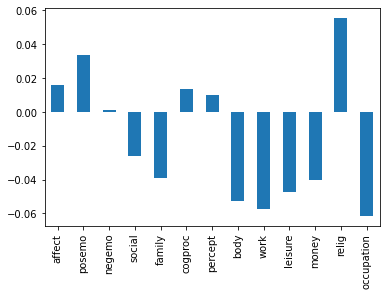

In [16]:
pop_bias.mean().plot.bar()

<AxesSubplot:>

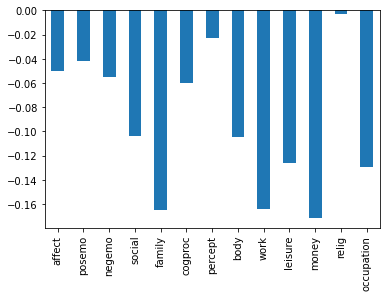

In [17]:
metal_bias.mean().plot.bar()

## Conclusions

The results seem coherent with my initial expectation:

- Pop seems to be biased towards men in some categories (social, family, body, work, leisure, money, occupation) and towards women in others (affect, posemo, negemo, cogproc, precept, relig). The bias seems to be rather slight, as it never goes beyond 0.07, although more pronounced in the categories whose bias is leaning towards male. 

- Metal, on the other hand, seems to be biased towards men in all categories. The bias here is more pronounced than it was for the pop model, reaching biases as high as .171 in favour of men. 

An interesting pattern to notice between the two charts is that the cateogries that have male bias for the pop model are the categories with the most male bias in for the metal model; also, religion, the category that has the lowest male bias for the metal model, has the highest female bias for the pop model. This can lead to think that both models assign similar bias scores, but the metal model always adds some extra male bias to the score.